In [ ]:
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

In [1]:
import os
import cv2
from matplotlib import pyplot as plt

In [3]:
! pwd

/home/vladimir/PersonalProjects/experiments/detector/yolo


In [2]:
os.listdir('./data/wider_face_split/')

FileNotFoundError: [Errno 2] No such file or directory: './data/wider_face_split/'

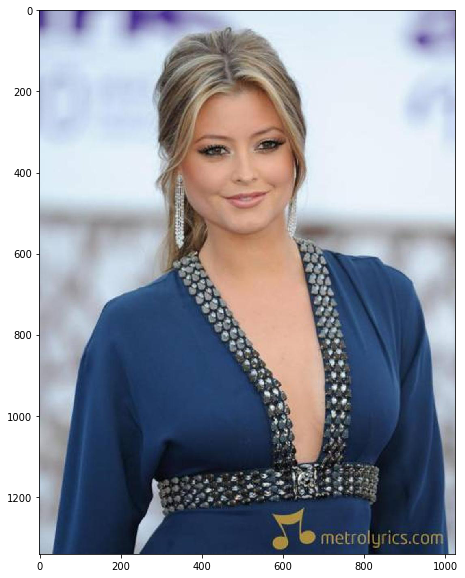

In [45]:
img_path = list(train_meta.keys())[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img);

In [ ]:
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

In [39]:
def read_meta_from_file(data_root_path):
    split_path = os.path.join(data_root_path, 'wider_face_split')
    train_data_path = os.path.join(data_root_path, 'WIDER_train/images')
    train_meta_path = os.path.join(split_path, 'wider_face_train_bbx_gt.txt')
    
    meta = {}

    with open(train_meta_path, 'r') as rfile:

        while True:

            short_file_path = rfile.readline()
            bbox_count = rfile.readline()

            if short_file_path == '' or bbox_count == '':
                rfile.close()
                break

            short_file_path = short_file_path.replace('\n', '')
            bbox_count = int(bbox_count.replace('\n', ''))
            
            full_file_path = os.path.join(train_data_path, short_file_path)
            
            gt_bboxes = []

            for _ in range(bbox_count):
                attributes = rfile.readline()
                attributes = attributes.replace('\n', '').split(' ')
                attributes = [int(att) for att in attributes if len(att) > 0]

                gt_bboxes.append(attributes)

            meta[full_file_path] = gt_bboxes
            
    return meta 

In [40]:
train_meta = read_meta_from_file(DATA_PATH)

In [46]:
list(train_meta.values())[0]

[[361, 202, 270, 354, 0, 0, 0, 0, 0, 0]]

In [1]:
import torch

In [15]:
a = torch.rand((10, 13))
a[:, 0] = 0
b, c = a[:, :2].t()
print(a[:, :2].t().shape)
b.shape, c.shape

torch.Size([2, 10])


(torch.Size([10]), torch.Size([10]))

In [ ]:
train.py --n_cpu 2 

In [ ]:
train.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                [--gradient_accumulations GRADIENT_ACCUMULATIONS]
                [--model_config_path MODEL_CONFIG_PATH]
                [--data_config_path DATA_CONFIG_PATH]
                [--weights_path WEIGHTS_PATH] [--class_path CLASS_PATH]
                [--n_cpu N_CPU] [--img_size IMG_SIZE]
                [--checkpoint_interval CHECKPOINT_INTERVAL]
                [--compute_map COMPUTE_MAP]
                [--multi_scale_training MULTI_SCALE_TRAINING]

In [ ]:
10,13,  16,30,  33,23

In [8]:
116 / (416 / 48)

13.384615384615385

In [11]:
for a in [  116,90,  156,198,  373,326, 30,61,  62,45,  59,119, 10,13,  16,30,  33,23,]:
    print(a / (416 / 13), a / (416 / 26), a / (416 / 52))

3.625 7.25 14.5
2.8125 5.625 11.25
4.875 9.75 19.5
6.1875 12.375 24.75
11.65625 23.3125 46.625
10.1875 20.375 40.75
0.9375 1.875 3.75
1.90625 3.8125 7.625
1.9375 3.875 7.75
1.40625 2.8125 5.625
1.84375 3.6875 7.375
3.71875 7.4375 14.875
0.3125 0.625 1.25
0.40625 0.8125 1.625
0.5 1.0 2.0
0.9375 1.875 3.75
1.03125 2.0625 4.125
0.71875 1.4375 2.875


In [ ]:
[ 3.6250,  2.8125],
[ 4.8750,  6.1875],
[11.6562, 10.1875],

[1.8750, 3.8125],
[3.8750, 2.8125],
[3.6875, 7.4375],

[1.2500, 1.6250],
[2.0000, 3.7500],
[4.1250, 2.8750],

In [24]:
import torch
(torch.tensor(2.923).long())

tensor(2)